## Module 1 : Fetch Data

In [1]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

# Config
folder = './data/'
train = 'train_aWnotuB.csv'
test = 'test_BdBKkAj_L87Nc3S.csv'
sub = 'sample_submission_KVKNmI7.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)


# df_copy = df.copy()

def __GetTimeSeriesCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe is single timeseries")
    return()


def __SetColumnNames(df, id_col, ds_col, target_col):
    df.rename(columns={ds_col: 'ds', id_col : 'ID', target_col : 'y'}, inplace=True)
#     df.set_index('ds', drop = False, inplace = True)
    return(df)

# Fix in train
train = _ReadCsv_pd(folder, train)
__GetTimeSeriesCount(train,"DateTime")
df = __SetColumnNames(train, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

#Fix in test
test = _ReadCsv_pd(folder, test)
__GetTimeSeriesCount(test,"DateTime")
test = __SetColumnNames(test, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

df.head()


train_aWnotuB.csv : Read csv to dataframe sucessfully
Shape of dataframe (48120, 4) Memory Usage 4812160
Dataframe is single timeseries
test_BdBKkAj_L87Nc3S.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 3) Memory Usage 1086496
Dataframe is single timeseries


,ds,Junction,y,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [2]:
cap_dict = {1: 156+30, 2: 48+30, 3: 180+30, 4: 36+30}

df["cap"] = df['Junction'].map(cap_dict)
test['cap'] = test['Junction'].map(cap_dict)

flr = df.y.min()
df['floor'] = flr
test['floor'] = flr
print (df)

                        ds  Junction   y           ID  cap  floor
0      2015-11-01 00:00:00         1  15  20151101001  186      1
1      2015-11-01 01:00:00         1  13  20151101011  186      1
2      2015-11-01 02:00:00         1  10  20151101021  186      1
3      2015-11-01 03:00:00         1   7  20151101031  186      1
4      2015-11-01 04:00:00         1   9  20151101041  186      1
...                    ...       ...  ..          ...  ...    ...
48115  2017-06-30 19:00:00         4  11  20170630194   66      1
48116  2017-06-30 20:00:00         4  30  20170630204   66      1
48117  2017-06-30 21:00:00         4  16  20170630214   66      1
48118  2017-06-30 22:00:00         4  22  20170630224   66      1
48119  2017-06-30 23:00:00         4  12  20170630234   66      1

[48120 rows x 6 columns]


## Module 2 : Clean Data

In [3]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe

df['ds'] = pd.to_datetime(df['ds'])
clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('ds')
print(cat_cols)

Null info in data:  0
These are the missing values proportions in each column
ds         0.00
Junction   0.00
y          0.00
ID         0.00
cap        0.00
floor      0.00
dtype: float64
% Missing data in each column 
 ()
[]


In [4]:
def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2015-11-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df, group_col='Junction')

#Since we see missing timesteps in group 4, we checked and found that group4 started at later date. Checking again:

def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2017-01-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df[clean_df['Junction'] == 4], group_col='Junction')

No missing timesteps for group 1
No missing timesteps for group 2
No missing timesteps for group 3
Missing timesteps for group 4
Group len VS Timesteps
4344 14592
No missing timesteps for group 4


()

## Module 3 : Pre-Proccess Model Data

In [5]:
# Helper functions
# Split dataframe
def __SplitTrainTest(X, prop = 0.95):
    '''Takes in the dataframe and proprtion of train size and returns the train and test sets'''
    X.sort_values(by='ds', ascending=True, inplace = True)
    train_size = int(len(X) * prop)
    train, test = X[0:train_size], X[train_size:len(X)]
    print("Min date train main", train.ds.min(), "Max date train main", train.ds.max())
    print("Min date test main", test.ds.min(), "Max date test main", test.ds.max())
    print("Length of train", len(train), "Length of test", len(test))
    return(train, test)




tr = []
ts = []
for i in clean_df.Junction.unique().tolist():
    print(i)
    i_Df = clean_df[clean_df['Junction'] == i]
    train_i_df, test_i_df = __SplitTrainTest(i_Df, prop = 0.80)
    tr.append(train_i_df)
    ts.append(test_i_df)
        
print("Got splits for all Junctions")
train_df = pd.concat(tr)
test_df = pd.concat(ts)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

1
Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-01 08:00:00
Min date test main 2017-03-01 09:00:00 Max date test main 2017-06-30 23:00:00
Length of train 11673 Length of test 2919
2
Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-01 08:00:00
Min date test main 2017-03-01 09:00:00 Max date test main 2017-06-30 23:00:00
Length of train 11673 Length of test 2919
3
Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-01 08:00:00
Min date test main 2017-03-01 09:00:00 Max date test main 2017-06-30 23:00:00
Length of train 11673 Length of test 2919
4
Min date train main 2017-01-01 00:00:00 Max date train main 2017-05-25 18:00:00
Min date test main 2017-05-25 19:00:00 Max date test main 2017-06-30 23:00:00
Length of train 3475 Length of test 869
Got splits for all Junctions


In [6]:
print("Shape of train", train_df.shape, "Shape of test", test_df.shape)

Shape of train (38494, 6) Shape of test (9626, 6)


## Module 4 : Exploratory Data Analysis

Distribution for
a
Cat col not found


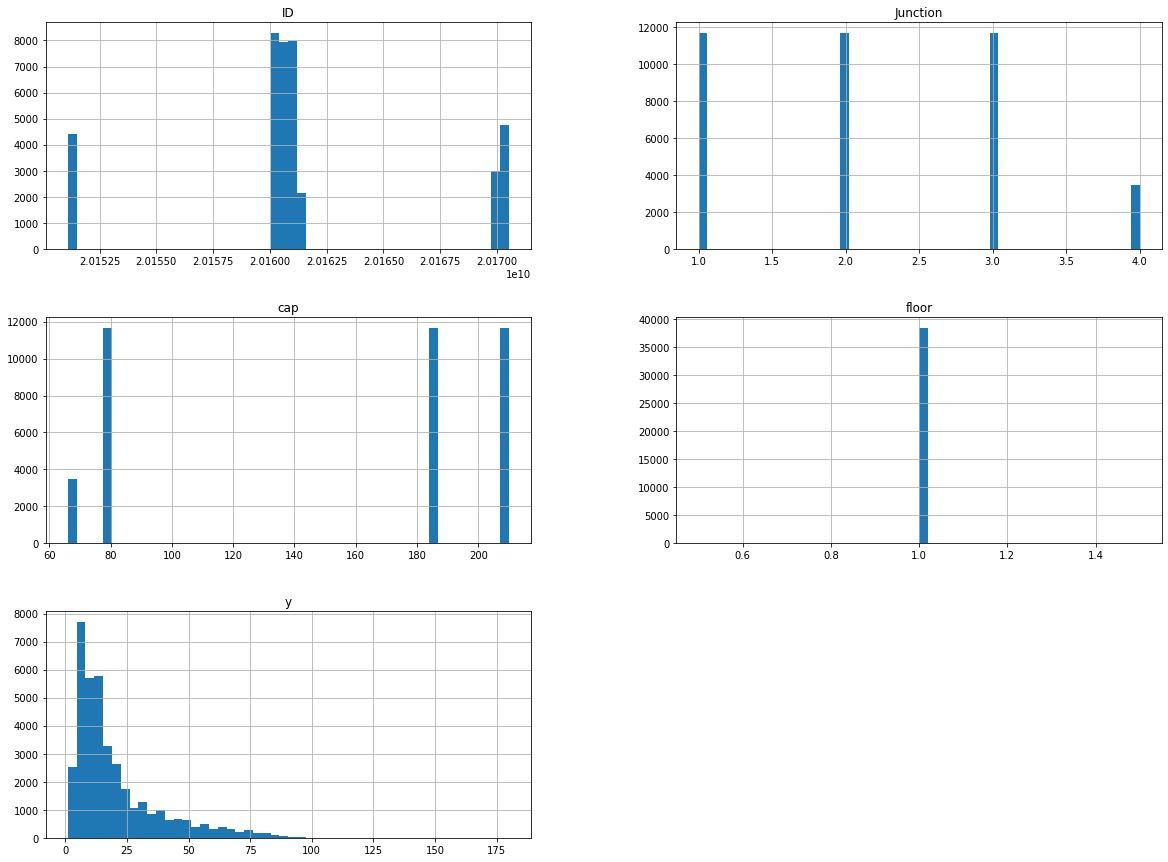

,Junction,y,ID,cap,floor
count,38494.00,38494.00,38494.00,38494.00,38494.00
mean,2.18,20.09,20161508221.60,149.69,1.00
std,0.97,17.85,5299209.07,60.78,0.00
min,1.00,1.00,20151101001.00,66.00,1.00
25%,1.00,8.00,20160313155.00,78.00,1.00
50%,2.00,14.00,20160725072.50,186.00,1.00
75%,3.00,25.00,20161205231.75,210.00,1.00
max,4.00,180.00,20170525184.00,210.00,1.00


In [7]:
def __ExploringDataframe(df, cat_list= ['a']):
    try:
        for col in cat_list:
            print("Distribution for")
            print(col)
            print(df[col].value_counts())
    except:
        print("Cat col not found")
    # Above data as plots
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    return()

__ExploringDataframe(train_df)

# Lets look at the rest of the fields - we can check out the numeric data using describe method
train_df.describe()

## Module 5 : Prepare Model Data

In [8]:
def __PrepModelDf(model_df):
    df = model_df.copy()
    df.set_index('ds', drop = False, inplace = True)
    df_id = df["ID"].copy()
    df = df.drop(["ID"], axis = 1)
    df = df.drop(["Junction"], axis = 1)
    return(df, df_id)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def __GetError(test, forecast):
    actual = pd.Series(test['y'])
    actual = actual.tolist()
    predictions = forecast['yhat']
    forecast['actual'] = actual
    min_val = min(actual)
    forecast['yhat'] = np.where(forecast['yhat'] < 0, min_val, forecast['yhat'])
    mape = mean_absolute_percentage_error(actual, forecast['yhat'])
    print(mape)
    return(forecast)


def __PlotPrediction(train, test, forecast):
    fig = plt.figure(facecolor='w', figsize=(20, 6))
    plt.plot(train.ds, train.y,  label='Train')
    plt.plot(test.ds, test.y,  label='Test')
    plt.plot(test.ds, forecast['yhat'],  label='Predicted')
    plt.show()
    return()


## Module 6: Detect Outliers using Prophet

In [9]:
from fbprophet import Prophet

def __ProphetForAnomalyDetection(train, test):
    '''Fits the prophet model on '''

    ls = []
    for i in train.Junction.unique().tolist():
#     for i in [4]:
        print(i)
        tr_i = train[train['Junction'] == i]
        ts_i = test[test['Junction'] == i]
        
        # Prep Data
        tr_df, tr_id = __PrepModelDf(tr_i)
        ts_df, ts_id = __PrepModelDf(ts_i)

        print("Shape of tr_df", tr_df.shape,"Shape of ts_df", ts_df.shape)
        #Fit model
        if i == 1:
            interval_width = 0.99
            changepoint_range = 0.1
            m1 = Prophet(growth='logistic', daily_seasonality = True, yearly_seasonality = True, weekly_seasonality = True,
                         seasonality_mode = 'multiplicative', interval_width = interval_width,
                         changepoint_range = changepoint_range) 
        elif i == 2:
            interval_width = 0.90
            changepoint_range = 0.8
            m1 = Prophet(growth='logistic', daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range) #18.3
            
        elif i == 3:
            
            interval_width = 0.99 
            changepoint_range = 0.1
            m1 = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True, 
                         seasonality_mode = 'multiplicative', interval_width = interval_width, 
                         changepoint_range = changepoint_range) 
        
        else:
            interval_width = 0.90 
            changepoint_range = 0.10
            m1 = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                         seasonality_mode = 'multiplicative', interval_width = interval_width, 
                         changepoint_range = changepoint_range)

        m1.fit(tr_df)
        forecast_tr = m1.predict(tr_df)
        forecast_ts = m1.predict(ts_df)
        __GetError(ts_df, forecast_ts)
        frames = [forecast_tr, forecast_ts]
        full_df = pd.concat(frames)
        
        print("Model trained")

        print("Predicting for actual test data")
        forecast_df = pd.DataFrame(full_df)


        forecast_df['ID'] = list(tr_id) + list(ts_id)
        forecast_df['Junction'] = i
        print("Shape of forecast_df", forecast_df.shape)
        
        try:
            actual_tr = pd.Series(tr_df['y'])
            actual_tr = actual_tr.tolist()
            actual_ts = pd.Series(ts_df['y'])
            actual_ts = actual_ts.tolist()
            forecast_df['actual'] = actual_tr + actual_ts
            forecast_df = forecast_df[['ID' , 'ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']]
        except:
            print("Predicting for actual test data")
            forecast_df = forecast_df[['ID', 'ds','trend', 'yhat', 'yhat_lower', 'yhat_upper']]
        
        ls.append(forecast_df)
        
    print("Got predictions for all Junctions")
    out_df = pd.concat(ls)
    out_df = out_df.reset_index(drop=True)
    try:
        print(mean_absolute_percentage_error(out_df.yhat, out_df.actual))
    except:
        pass
    return(out_df)

In [10]:
prophet_df = __ProphetForAnomalyDetection(train_df, test_df)

1
Shape of tr_df (11673, 4) Shape of ts_df (2919, 4)
14.227595511958102
Model trained
Predicting for actual test data
Shape of forecast_df (14592, 27)
2
Shape of tr_df (11673, 4) Shape of ts_df (2919, 4)
14.75052864478075
Model trained
Predicting for actual test data
Shape of forecast_df (14592, 24)
3
Shape of tr_df (11673, 4) Shape of ts_df (2919, 4)
38.720652902306774
Model trained
Predicting for actual test data
Shape of forecast_df (14592, 23)
4
Shape of tr_df (3475, 4) Shape of ts_df (869, 4)
33.924238927410514
Model trained
Predicting for actual test data
Shape of forecast_df (4344, 23)
Got predictions for all Junctions
25.09392867978473


In [11]:
def detect_anomalies(forecast):
    forecasted = forecast[['ID' ,'ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'actual']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['actual'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['actual'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['actual'] - forecasted['yhat_upper'])/forecast['actual']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['actual'])/forecast['actual']
    
    return forecasted

pred = detect_anomalies(prophet_df)

In [12]:
print(pred.groupby('anomaly').nunique())
pred['is_anomaly'] = np.where(pred['importance'] >= 0.6, 1, 0)
print(pred.groupby('is_anomaly').nunique())
anomaly_df = pred[['ID', 'is_anomaly']]

            ID     ds  trend   yhat  yhat_lower  yhat_upper  actual  anomaly  importance
anomaly                                                                                 
-1        1066    952   1066   1066        1066        1066      86        1        1066
 0       45225  14592  45225  45225       45225       45225     121        1           1
 1        1829   1627   1829   1829        1829        1829     132        1        1829
               ID     ds  trend   yhat  yhat_lower  yhat_upper  actual  anomaly  importance  is_anomaly
is_anomaly                                                                                             
0           48020  14592  48020  48020       48020       48020     137        3        2796           1
1             100     99    100    100         100         100      33        2         100           1


In [13]:
print("Shape of train", train_df.shape)
train_df = pd.merge(train_df, anomaly_df, on='ID', how = 'left')
print("Shape of train", train_df.shape)

Shape of train (38494, 6)
Shape of train (38494, 7)


In [14]:
print("Shape of test", test_df.shape)
test_df = pd.merge(test_df, anomaly_df, on='ID', how = 'left')
print("Shape of test_df", test_df.shape)

Shape of test (9626, 6)
Shape of test_df (9626, 7)


In [15]:
train_df['y'] = np.where(train_df['is_anomaly'] == 1, np.NaN, train_df['y'])
train_df = train_df.drop(["is_anomaly"], axis = 1)
test_df['y'] = np.where(test_df['is_anomaly'] == 1, np.NaN, test_df['y'])
test_df = test_df.drop(["is_anomaly"], axis = 1)

In [16]:
print("Shape of train_df", train_df.shape)
print("Shape of test_df", test_df.shape)

Shape of train_df (38494, 6)
Shape of test_df (9626, 6)


## Module 7 : Train Model

In [35]:


def __ProphetFit(train, test):
    '''Fits the prophet model on train test and predicts. Returns predicted dataframe '''

    ls = []
#     for i in train.Junction.unique().tolist():
    for i in [3]:
        print(i)
        tr_i = train[train['Junction'] == i]
        ts_i = test[test['Junction'] == i]
        
        # Prep Data
        tr_df, tr_id = __PrepModelDf(tr_i)
        ts_df, ts_id = __PrepModelDf(ts_i)
        
        print("Shape of train", tr_df.shape, "Shape of test", ts_df.shape)
        #Fit model
        if i == 1:
            interval_width = 0.99
            changepoint_range = 0.1
            m1 = Prophet(growth='logistic', daily_seasonality = True, yearly_seasonality = True, weekly_seasonality = True,
                         seasonality_mode = 'multiplicative', interval_width = interval_width,
                         changepoint_range = changepoint_range) 
        elif i == 2:
            interval_width = 0.90
            changepoint_range = 0.815
            m1 = Prophet(growth='logistic', daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range) #18.3
            
        elif i == 3:
            
            interval_width = 0.99 
            changepoint_range = 0.1
            m1 = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True, 
                         seasonality_mode = 'multiplicative', interval_width = interval_width, 
                         changepoint_range = changepoint_range) 
        
        else:
            interval_width = 0.90 
            changepoint_range = 0.10
            m1 = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                         seasonality_mode = 'multiplicative', interval_width = interval_width, 
                         changepoint_range = changepoint_range) 
        m1.fit(tr_df)


        forecast = m1.predict(ts_df)
        print("Model trained")
        # Plots
        # fig1 = m1.plot(forecast)
        # fig2 = m1.plot_components(forecast)
        try:
            forecast_df = __GetError(ts_df, forecast)
            __PlotPrediction(tr_df, ts_df, forecast_df)
        except:
            print("Predicting for actual test data")
            forecast_df = pd.DataFrame(forecast)
        
        forecast_df['ID'] = list(ts_id)
        forecast_df['Junction'] = i
        print("Shape of forecast_df", forecast_df.shape)
        
        try:
            forecast_df = forecast_df[['ID', 'actual', 'yhat']]
        except:
            print("Predicting for actual test data")
            forecast_df = forecast_df[['ID', 'yhat']]
    
        forecast_df.rename(columns={'yhat': 'Vehicles'}, inplace=True)
        
        ls.append(forecast_df)
        
    print("Got predictions for all Junctions")
    out_df = pd.concat(ls)
    try:
        print(mean_absolute_percentage_error(out_df.actual, out_df.Vehicles))
    except:
        pass
    return(out_df)

3
Shape of train (11673, 4) Shape of test (2919, 4)
Model trained
nan


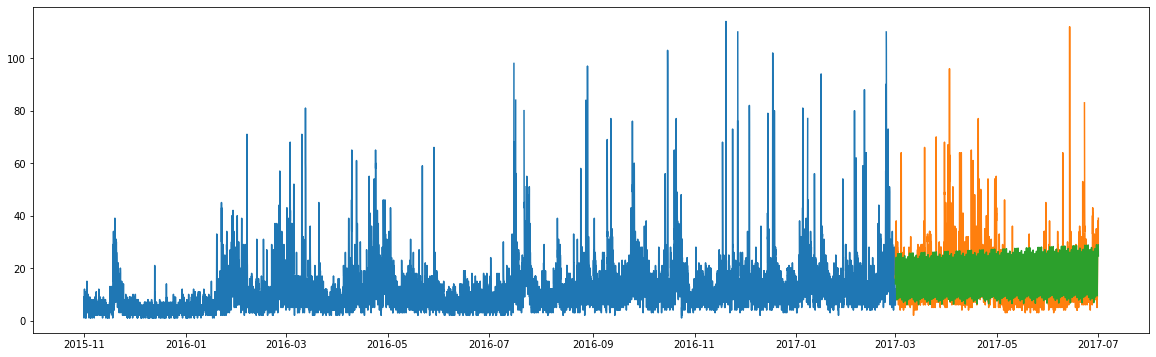

Shape of forecast_df (2919, 23)
Got predictions for all Junctions
nan


In [36]:
test_predicted_df = __ProphetFit(train_df, test_df)

In [19]:
predict_df = __ProphetFit(clean_df, test)

1
Shape of train (14592, 4) Shape of test (2952, 3)
Model trained
Predicting for actual test data
Shape of forecast_df (2952, 26)
Predicting for actual test data
2
Shape of train (14592, 4) Shape of test (2952, 3)
Model trained
Predicting for actual test data
Shape of forecast_df (2952, 23)
Predicting for actual test data
3
Shape of train (14592, 4) Shape of test (2952, 3)
Model trained
Predicting for actual test data
Shape of forecast_df (2952, 22)
Predicting for actual test data
4
Shape of train (4344, 4) Shape of test (2952, 3)
Model trained
Predicting for actual test data
Shape of forecast_df (2952, 22)
Predicting for actual test data
Got predictions for all Junctions


In [20]:
len(test)

11808

In [21]:
len(predict_df)

11808

In [23]:
predict_df['Vehicles'] = predict_df['Vehicles'].astype(float).round().astype(int)

In [24]:
predict_df.head()

,ID,Vehicles
0,20170701001,71
1,20170701011,60
2,20170701021,49
3,20170701031,40
4,20170701041,33


## Module 8 : Predict

In [25]:
sub_df = _ReadCsv_pd(folder, sub)
sub_df.head()

sample_submission_KVKNmI7.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 2) Memory Usage 189088


,ID,Vehicles
0,20170701001,50
1,20170701011,50
2,20170701021,50
3,20170701031,50
4,20170701041,50


In [26]:
output_directory = "./submissions/"
predict_df.to_csv(output_directory + "ruhama_submission9.csv", index=False)